This File contains a simple example usage for one of the models in the repository (the Learned Primal Dual trained under 'default' settings) for proof of concept.

In [1]:
# Import necessary libraries
import torch
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from src.models.primal_dual_nets import PrimalDualNet as LPD
from src.utils import add_noise
from src.dataloader import TestDataset
from torch.utils.data import DataLoader
import tomosipo as ts
from ts_algorithms import fbp


In [2]:
target_path = '../data/ground_truth_test/'
input_path = '../data/observation_test/'
dataset = TestDataset(target_path, input_path)

# set up the dataloader
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [3]:
# Load the trained model
input_dimension = 362
n_detectors = 543
n_primal = 5
n_dual = 5
n_iterations = 10
n_angles = 1000

vg = ts.volume(
    size=(1 / input_dimension, 1, 1), shape=(1, input_dimension, input_dimension)
)
pg = ts.parallel(
    angles=n_angles,
    shape=(1, n_detectors),
    size=(1 / input_dimension, n_detectors / input_dimension),
)

A = ts.operator(vg, pg)

model = LPD(vg, pg)
dicts = torch.load('../checkpoints/LPD_checkpoints_default/checkpoint_epoch50.pt')
model.load_state_dict(dicts['model_state_dict'])
model.cuda()


PrimalDualNet(
  (primal_list): ModuleList(
    (0-9): 10 x PrimalNet(
      (conv1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): PReLU(num_parameters=32)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): PReLU(num_parameters=32)
      (conv3): Conv2d(32, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (dual_list): ModuleList(
    (0-9): 10 x DualNet(
      (conv1): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): PReLU(num_parameters=32)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): PReLU(num_parameters=32)
      (conv3): Conv2d(32, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

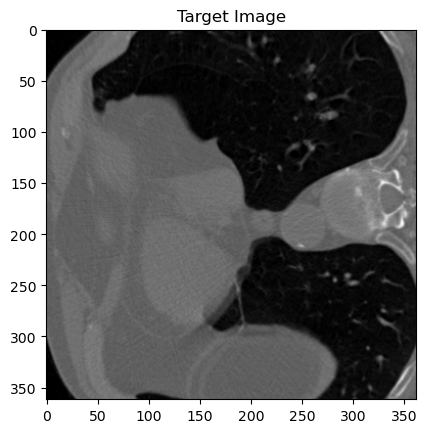

In [4]:
# Load an image from the test set
for i, data in enumerate(test_dataloader):
    _, target = data
    target = target.cuda()
    break

# Visualise the target image
plt.figure()
plt.imshow(target.cpu().detach().numpy().squeeze(), cmap='gray')
plt.title('Target Image')
plt.show()


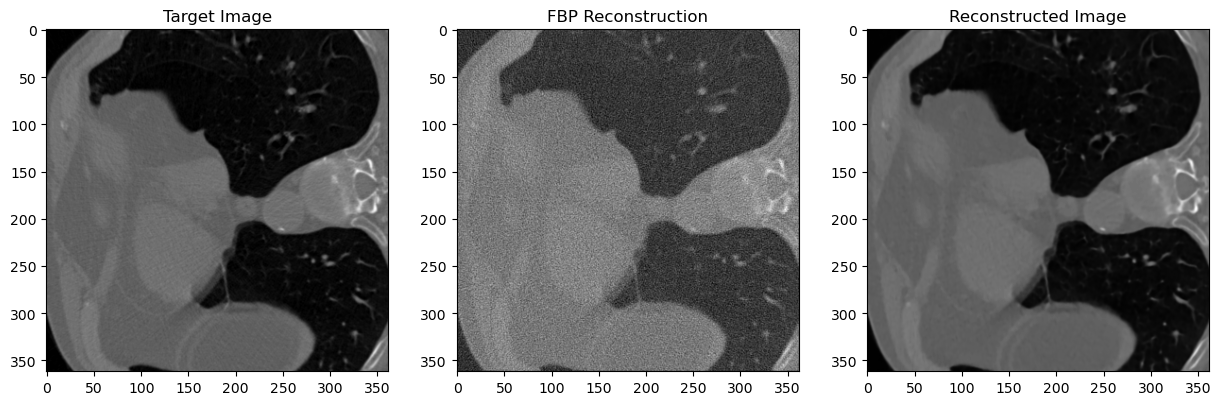

In [5]:
# Reconstruction using the trained model
# First create a noisy input
noisy_input = add_noise(target, n_detectors=n_detectors, n_angles=n_angles)

reconstruction = model(noisy_input)
reconstruction = reconstruction.cpu().detach().numpy().squeeze()

# Visualise the reconstructed image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(target.cpu().detach().numpy().squeeze(), cmap='gray')
plt.title('Target Image')
plt.subplot(1, 3, 2)
plt.imshow(fbp(A, noisy_input).cpu().detach().numpy().squeeze(), cmap='gray')
plt.title('FBP Reconstruction')
plt.subplot(1, 3, 3)
plt.imshow(reconstruction, cmap='gray')
plt.title('Reconstructed Image')
plt.show()